 Rossman Store Sales Prediction

## IMPORTS

In [1]:
import math
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import inflection
import datetime
import warnings
import random
import pickle

import xgboost as xgb

from tabulate                import tabulate
from pandas.api.types        import is_string_dtype, is_numeric_dtype
from matplotlib              import gridspec
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from boruta                  import BorutaPy

from IPython.core.display    import HTML
from IPython.display         import Image

# Versão da Linguagem Python
from platform                import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())
warnings.filterwarnings( 'ignore' )

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.1


### Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error ( model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib



### Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

In [6]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## DATA DISCRIPTION

In [7]:
#Copy dataset
df1 = df_raw.copy()

### Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

#Rename Columns

df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### Data Dimension

In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


### Data Types

In [11]:
#Change datatype of column data to datetime
df1['date'] = pd.to_datetime( df1[ 'date' ] )
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### Check NA values

In [12]:
#Checking NA values sum
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.00
day_of_week,0,0.00
date,0,0.00
sales,0,0.00
customers,0,0.00
open,0,0.00
promo,0,0.00
state_holiday,0,0.00
school_holiday,0,0.00
store_type,0,0.00


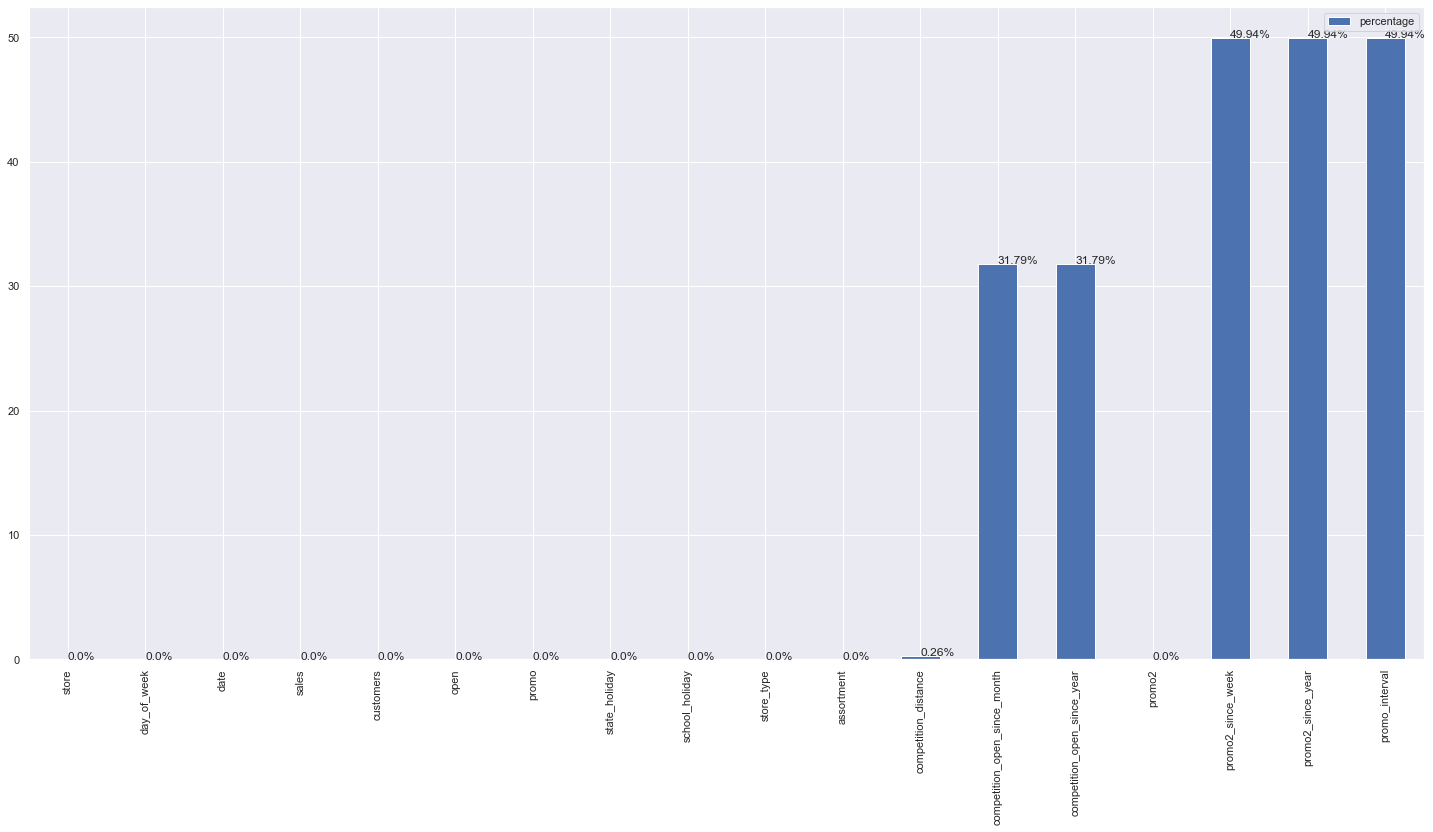

In [13]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

### Fillout NA

In [14]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],
                                               axis = 1 )
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'],
                                               axis = 1 )
# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'],
                                               axis = 1 )
# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'],
                                               axis = 1 )
# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### Change Types

In [18]:
df1 = df1.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64', 'promo2_since_week':'int64', 'promo2_since_year':'int64' })

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### Descriptive Statistics

In [ ]:
df1.describe().T

In [ ]:
num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

#### Numerical Attributes

In [ ]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

#### Categorical Attributes

In [ ]:
cate_attributes.apply( lambda x: x.unique().shape[0])

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data=aux1);

plt.subplot (1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data=aux1);

plt.subplot (1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data=aux1);

## FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

### Hypothesis Mindmap

In [ ]:
Image('img/DAILY_STORE_SALES_HYPOTESES.png')

### Creating Hypothesis

#### Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### Product Hypothesis 

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### Final Hypothesis List

In [ ]:
# Priorização baseado nos atributos disponíveis no dataset

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


### Feature Engineering

In [ ]:
df2.dtypes

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1 ), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( 'int64' )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [ ]:
df2.head().T

In [22]:
df2.state_holiday.unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

## VARIABLE FILTERING 

In [23]:
df3 = df2.copy()

### Line Filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales']> 0)]

### Columns Selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [ ]:
df3.head()

## EXPLORATORY DATA ANALYSIS (EDA)

In [26]:
df4 = df3.copy()

In [ ]:
df4.head()

### Univariate Analysis

#### Response Variable

In [ ]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['sales'], kde = False)

#### Numerical Variable

In [ ]:
num_attributes.hist(bins = 25);

#### Categorical Variable

In [ ]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True )
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data = df4, x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'a']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'b']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'c']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'd']['sales'], shade = True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(data = df4, x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'basic']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extended']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extra']['sales'], shade = True)

### Bivariate Analysis

#### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem menos!

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot( color = 'g' );

#### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(3, 1, 1)
sns.scatterplot(x= 'competition_distance', y= 'sales', data= aux1);

plt.subplot(3, 1, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation = 20)
sns.barplot( x= 'competition_distance_binned', y= 'sales', data = aux2);

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

#### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com competidores à mais tempo VENDEM MENOS!.

In [ ]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x= 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSE** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.


In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(data = aux2, x= 'promo_time_week', y= 'sales')
plt.xticks(rotation= 90);

plt.subplot(grid[0,1])
sns.regplot(data = aux2, x= 'promo_time_week', y= 'sales')

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(data = aux3, x= 'promo_time_week', y= 'sales')
plt.xticks(rotation= 90);

plt.subplot(grid[1,1])
sns.regplot(data = aux3, x= 'promo_time_week', y= 'sales');

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method = 'pearson'), annot = True);

#### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>


#### H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSE** Lojas com mais promoções consecutivas VENDEM MENOS!

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending = True)

In [ ]:
aux1 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax )

ax.legend( labels = ['Tradicional & Extendida', 'Extendida']);

#### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSE** Lojas abertas durante o feriado de Natal não vendem mais

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = aux1, x= 'state_holiday', y= 'sales');

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data = aux2, x = 'year', y= 'sales', hue= 'state_holiday');

#### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSE** Lojas vendem MENOS ao longo dos anos

In [ ]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'year', y= 'sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'year', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

#### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** Lojas vendem menos no segundo semestre do ano

In [ ]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'month', y= 'sales');   ###*tentar colocar legenda no gráfico em cima do semestre que vende menos*###

plt.subplot(132)
sns.regplot(data = aux, x= 'month', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);



#### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**TRUE** Lojas vendem mais depois do dia 10


In [ ]:
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()

fig = plt.figure(figsize = (18,12))
plt.subplot(231)
sns.barplot(data = aux, x= 'day', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(222)
sns.regplot(data = aux, x= 'day', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(223)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else
                                                  'after_10_days')

aux1 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(224)
sns.barplot(data = aux1, x= 'before_after', y= 'sales');



#### **H12.** Lojas deveriam vender menos aos finais de semana.
**TRUE** lojas vendem menos aos finais de semana!

In [ ]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'day_of_week', y= 'sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'day_of_week', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

#### **H13.** Lojas deveriam vender menos durante os feriados escolares
**TRUE** lojas vendem menos durante os feriados escolares. Exceto no mês de Agosto vendem mais

In [ ]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index();

fig = plt.figure(figsize = (18,12))
plt.subplot(211)
sns.barplot(data = aux, x= 'school_holiday', y= 'sales');

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index();

plt.subplot(212)
sns.barplot(data = aux2, x= 'month', y= 'sales', hue= 'school_holiday');
plt.xticks(rotation = 45);

#### Hypothesis summarize

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

### Multivariate Analysis

#### Numerical Attributes

In [ ]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

#### Categorical Attributes

In [ ]:
# Only categorical attributes
a = df4.select_dtypes( include = 'object')

# Calculate and create cramer_v matrix

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index( d.columns) # Setting index name iqual columns name
d

In [ ]:
sns.heatmap(d, annot = True);

## DATA PREPARATION

In [66]:
df5 = df4.copy()

In [67]:
df5.state_holiday.unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

### Feature Normalization

**None of the attributes follow a normal distribution**

### Feature Rescaling

In [68]:
rs = RobustScaler()  #seleção do método de rescaling é devido aos outliers - adicionar explicação
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values ) 
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open('parameters/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(rs, open('parameters/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('parameters/year_scaler.pkl', 'wb'))

In [ ]:
sns.distplot(df5['competition_distance'])

### Feature Transformation

#### Encoding

In [30]:
df5.select_dtypes( include = 'object').head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [69]:
# state_holiday (it's a state, holidays are moments) - One Hot Enconding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'], dtype = 'int64' )

# store_type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open('parameters/store_type_scaler', 'wb'))

# assortment - Ordinal Encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

#### Response Variable Transformation

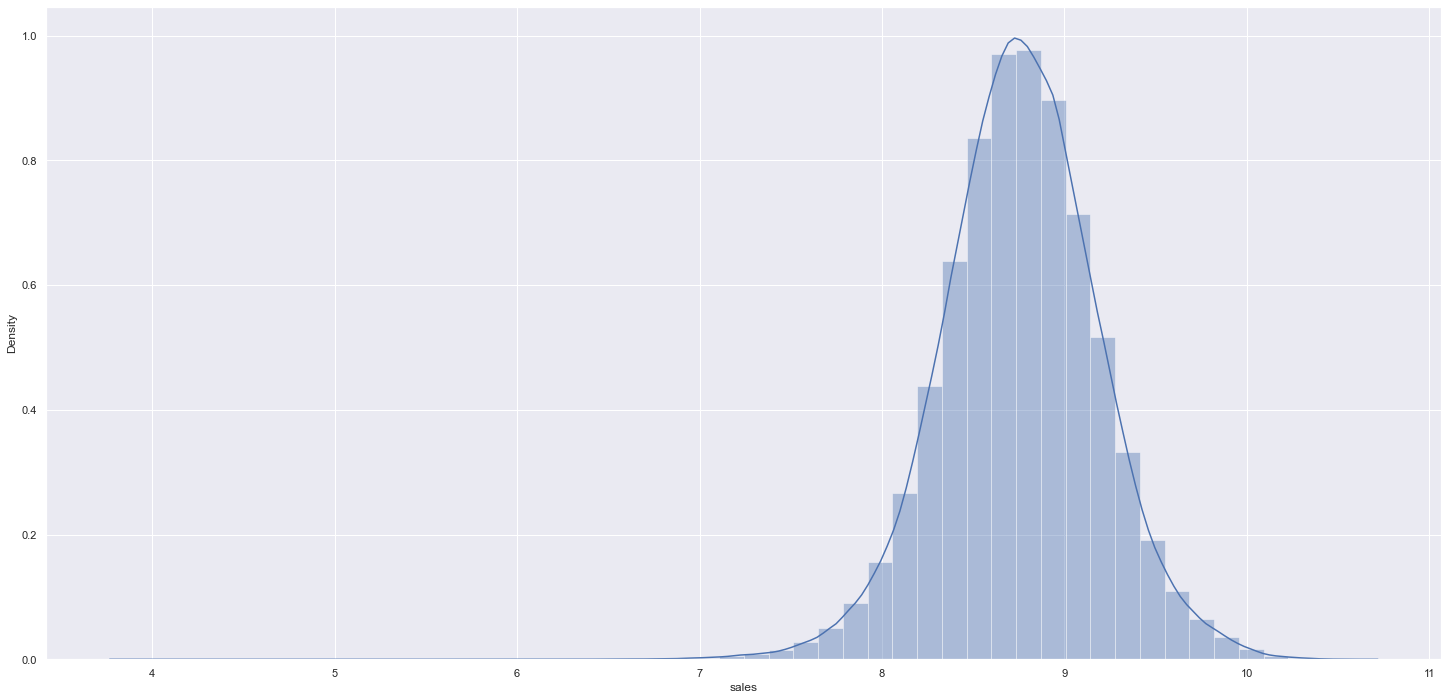

In [70]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot(df5['sales']);

#### Nature Transformation

In [72]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [73]:
df5 = df5.astype({'store_type': 'int64'})
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

## FEATURE SELECTION

In [74]:
df6 = df5.copy()

In [75]:
# deleting features after feature engineering derivation. Deleting original variables.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

### Split dataframe into training and test dataset

In [38]:
# Spliting dataframe into training and test. Test will have the last 6 weeks of sales, starting at 2015-06-19 until the last day of sales

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [39]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### Boruta as a Feature Selector

In [ ]:
# # training and test dataset for Boruta, because it can't be a dataframe type
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### Best Features from Boruta

In [ ]:
X_train.columns

In [ ]:
# cols_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[ :, cols_selected].columns.tolist()

# # Not selected boruta features
# cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [ ]:
# X_filtered = boruta.transform(X_train_n) # call transform() on X to filter it down to selected features

In [ ]:
# cols_not_selected_boruta

In [ ]:
# cols_selected_boruta

### Manual Feature Selection

In [40]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [ ]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

## MACHINE LEARNING ALGORITHM MODELS

In [41]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

### Average Model

In [ ]:
# modelo de média é o modelo que mais usamos no dia a dia, a simples média, ele sempre vai prever a média. 
# É útil pois é uma base comparativa para implementação de outros modelosb

# analisando o resultado dos erros de cada modelo testado, percebe-se que erros maiores aconteceram nas regressões lineares
## ou seja, o conjunto de dados é complexo, não segue uma linearidade. Modelos apresentaram erros maiores que a média!

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how= 'left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ))
baseline_result

### Linear Regression Model

In [ ]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction 
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

#### Linear Regression Model - Cross Validation

In [ ]:
#lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

### Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

#### Linear Regression Regularized Model - Lasso

In [ ]:
#lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Regularized Model - Lasso', lrr, verbose=False )

### Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1, random_state=7 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

#### Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )

### XGBoost Regressor

In [42]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators = 100,
                              eta = 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytree = 0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.408009,0.949433,7330.688281


#### XGBoost Regressor - Cross Validation

In [ ]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )

### Compare Model's Performance

#### Single Performance

In [ ]:
results = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
results.sort_values('RMSE')

#### Real Performance - Cross Validation

In [ ]:
#results_cv = pd.concat([lr_result_cv , lrr_result_cv , rf_result_cv, xgb_result_cv])
#results_cv

## HYPERPARAMETERS FINE TUNING

### Random Search

In [ ]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
#         }

# MAX_EVAL = 5; #quantas iterações temos

In [ ]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators = hp['n_estimators'],
#                                   eta = hp['eta'],
#                                   max_depth = hp['max_depth'],
#                                   subsample = hp['subsample'],
#                                   colsample_bytree = hp['colsample_bytree'],
#                                   min_child_weight = hp['min_child_weight'])
    
#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#     final_result = pd.concat([final_result, result])

# final_result


### Final Model

In [43]:
param_tuned = {
    'n_estimators':1700 ,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7 ,
    'min_child_weight': 15
        }

In [44]:
# model
model_xgb_tuned = xgb.XGBRegressor(  objective='reg:squarederror',
                                      n_estimators = param_tuned['n_estimators'],
                                      eta = param_tuned['eta'],
                                      max_depth = param_tuned['max_depth'],
                                      subsample = param_tuned['subsample'],
                                      colsample_bytree = param_tuned['colsample_bytree'],
                                      min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_tuned_result = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb_tuned))
xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,640.403653,0.093385,936.130891


In [45]:
xgb_tuned_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )

KeyboardInterrupt: 

In [46]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.0003802979041946542

## ERROR INTERPRETATION 

In [47]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### Business Performance

In [48]:
# sum of prediction
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenerios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [49]:
# worst and best scenarios
df92.sort_values('MAE', ascending = True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
472,473,125713.585938,125466.887774,125960.284101,246.698163,0.082900
888,889,152603.578125,152352.498727,152854.657523,251.079398,0.064172
793,794,119579.531250,119316.193716,119842.868784,263.337534,0.078700
306,307,99618.687500,99346.770620,99890.604380,271.916880,0.112116
164,165,145327.078125,145053.122044,145601.034206,273.956081,0.069691


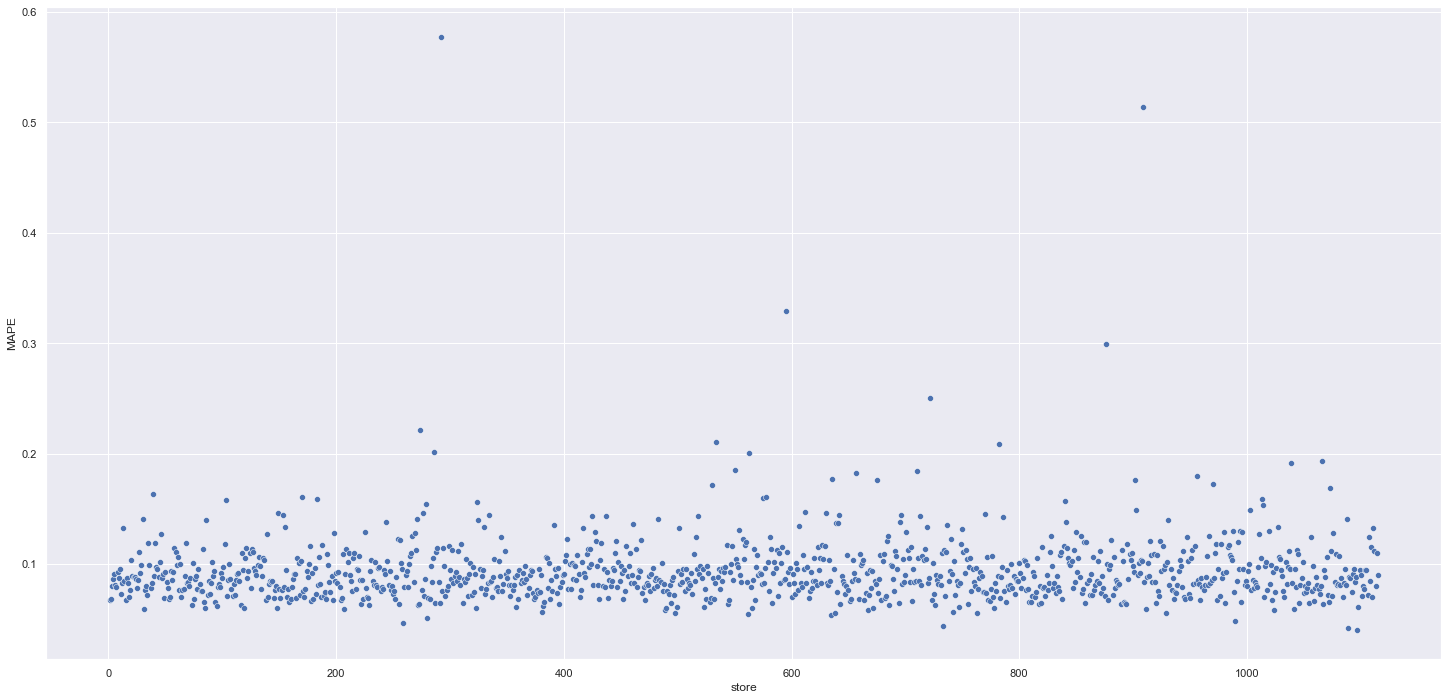

In [50]:
# scatterplot
sns.scatterplot(x = 'store', y = 'MAPE', data = df92 );

### Total Performance

In [51]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$ 284,356,928.00"
1,worst_scenario,"R$ 283,638,797.34"
2,best_scenario,"R$ 285,075,045.66"


### Machine Learning Performance 

In [52]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

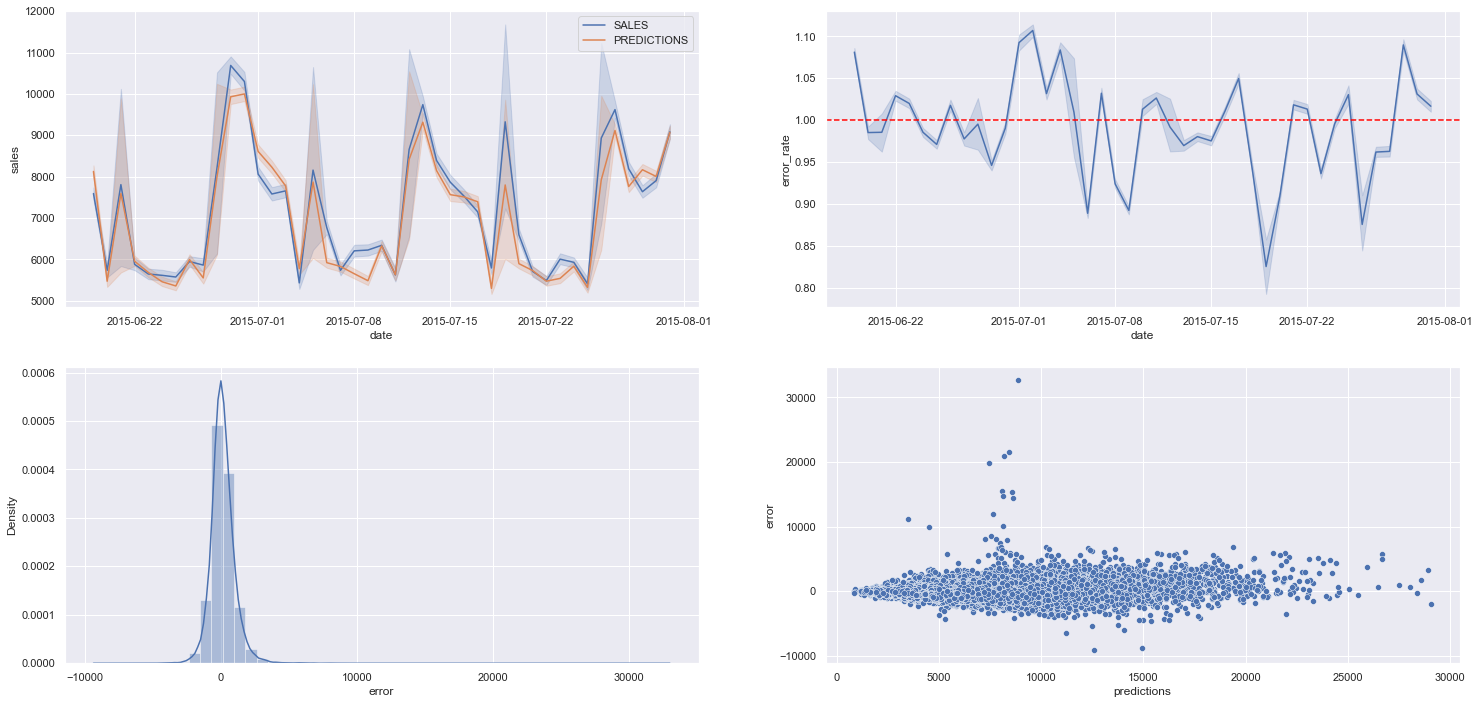

In [53]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--', color = 'red')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

## MODEL DEPLOYMENT

In [ ]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

### Rossmann Class

In [ ]:
import pickle
import pandas as pd
import numpy as np
import math
import datetime
import inflection

class Rossmann(object): # a classe rossman recebe um objeto. Iremos colocar todas limpezas, transformações, encondings
    def __init__(self): 
        self.home_path                     = 'C:/Users/marxv/Documents/DataScience/Data-Science-Projects/Kaggle-Rossman-Sales-Prediction/'
        self.competition_distante_scaler   = pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameters/year_scaler.pkl', 'rb'))    
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameters/store_type_scaler', 'rb'))
        
    def data_cleaning(self, df1):

        ### Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list( map( snakecase, cols_old ) )

        #Rename Columns
        df1.columns = cols_new

        #Change datatype of column data to datetime
        df1['date'] = pd.to_datetime( df1[ 'date' ] )
        
        # Fillout NA values
        # competition_distance         
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],
                                                    axis = 1 )
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'],
                                                    axis = 1 )
        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'],
                                                    axis = 1 )
        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'],
                                                    axis = 1 )
        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna( 0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ### Change Types
        df1 = df1.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64', 'promo2_since_week':'int64', 'promo2_since_year':'int64' })
        
        return df1

    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1 ), axis = 1)
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( 'int64' )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        ### Line Filtering
        df2 = df2[df2['open'] != 0]

        ### Columns Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation(self, df5):
        # Rescaliing
        # competition distance
        df5['competition_distance'] = self.competition_distante_scaler.fit_transform( df5[['competition_distance']].values ) 
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### Feature Transformation
        #### Encoding

        # state_holiday (it's a state, holidays are moments) - One Hot Enconding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'], dtype  = 'int64' )

        # store_type - Label Encoder
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        # assortment - Ordinal Encoder
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        #### Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        # Converting dtypes after transformation
        print(df5.columns)
        df5 = df5.astype({'store_type': 'int64' })
        # df5 = df5.astype({'store_type': 'int64' ,'state_holiday_christmas':'int64', 'state_holiday_easter_holiday':'int64', 'state_holiday_public_holiday':'int64', 'state_holiday_regular_day':'int64' })

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos','month_cos', 'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data so people can undestandt it the new table with prediction column
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

### API Handler

In [54]:
import pickle
import pandas as pd
from flask            import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:/Users/marxv/Documents/DataScience/Data-Science-Projects/Kaggle-Rossman-Sales-Prediction/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    # Converting json in dataframe
    if test_json: # there is data
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index = [0])
        
        else: # Multiple examples
            test_raw = pd.DataFrame(test_json, columns = test_jason[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0') #indicando o localhost p/ simular

ModuleNotFoundError: No module named 'rossmann'

### API Tester

In [5]:
import requests

In [6]:
# loading test dataset
df10 = pd.read_csv('C:/Users/marxv/Documents/DataScience/Data-Science-Projects/Kaggle-Rossman-Sales-Prediction/data/test.csv')

In [7]:
# merge test dataset + store attributes dataset
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [8]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [97]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict' #endpoint #porta 5000 é do flask
url = 'https://rossmann-model-pred.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } #indica para a api qual tipo de dados que estamos recebendo
data = data

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [98]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,0,0,a,c,1070.0,9.0,2015.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Sep,0,6545.956543
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,0,0,a,a,1040.0,9.0,2015.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct",Sep,0,3947.366943
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",Sep,0,6276.212891
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,0,0,a,c,1070.0,9.0,2015.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Sep,0,6546.468262
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,0,0,a,a,1040.0,9.0,2015.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct",Sep,0,4111.592285


In [99]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction']) )
    
# for i in range( len( d2 ) ):
#     print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
#             d2.loc[i, 'store'], 
#             d2.loc[i, 'prediction'] ) )

Store Number 12 will sell R$ 248,855.54 in the next 6 weeks
Store Number 22 will sell R$ 147,492.32 in the next 6 weeks
Store Number 24 will sell R$ 247,536.25 in the next 6 weeks
